In [1]:
import pypesto
import amici
import petab

import os
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# a collection of models that can be simulated

folder_base = "/home/yannik/benchmark-models-petab/Benchmark-Models"
model_name = "Zheng_PNAS2012"
#model_name = "Boehm_JProteomeRes2014"
model_name = "Fujita_SciSignal2010"
#model_name = "Sneyd_PNAS2002"
#model_name = "Borghans_BiophysChem1997"
#model_name = "Elowitz_Nature2000"
#model_name = "Crauste_CellSystems2017"
#model_name = "Lucarelli_CellSystems2018"
#model_name = "Schwen_PONE2014"
#model_name = "Blasi_CellSystems2016"
#model_name = "Chen_MSB2009"

# the yaml configuration file links to all needed files
yaml_config = os.path.join(folder_base, model_name, model_name + '.yaml')

# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

In [18]:
importer = pypesto.PetabImporter(petab_problem)

model = importer.create_model()

import libsbml
converter_config = libsbml.SBMLLocalParameterConverter()\
    .getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

2020-04-14 12:22:23.041 - amici.petab_import - INFO - Importing model ...
2020-04-14 12:22:23.049 - amici.petab_import - INFO - Model name is 'Fujita_SciSignal2010'. Writing model code to '/home/yannik/pypesto/doc/example/amici_models/Fujita_SciSignal2010'.
2020-04-14 12:22:23.058 - amici.petab_import - INFO - Species: 9
2020-04-14 12:22:23.060 - amici.petab_import - INFO - Global parameters: 17
2020-04-14 12:22:23.064 - amici.petab_import - INFO - Reactions: 11
2020-04-14 12:22:23.091 - amici.petab_import - INFO - Observables: 3
2020-04-14 12:22:23.093 - amici.petab_import - INFO - Sigmas: 3
2020-04-14 12:22:23.105 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict([('observableParameter1_pAkt_tot', None), ('observableParameter1_pEGFR_tot', None), ('observableParameter1_pS6_tot', None), ('noiseParameter1_pAkt_tot', None), ('noiseParameter1_pEGFR_tot', None), ('noiseParameter1_pS6_tot', None)])
2020-04-14 12:22:23.110 - amici.petab_import - DEBUG - Condition 

running build_ext
building 'Fujita_SciSignal2010._Fujita_SciSignal2010' extension
swigging swig/Fujita_SciSignal2010.i to swig/Fujita_SciSignal2010_wrap.cpp
swig -python -c++ -modern -outdir Fujita_SciSignal2010 -I/home/yannik/amici/python/sdist/amici/swig -I/home/yannik/amici/python/sdist/amici/include -o swig/Fujita_SciSignal2010_wrap.cpp swig/Fujita_SciSignal2010.i
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/swig
gcc -pthread -B /home/yannik/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/yannik/pypesto/doc/example/amici_models/Fujita_SciSignal2010 -I/home/yannik/amici/python/sdist/amici/include -I/home/yannik/amici/python/sdist/amici/ThirdParty/gsl -I/home/yannik/amici/python/sdist/amici/ThirdParty/sundials/include -I/home/yannik/amici/python/sdist/amici/ThirdParty/SuiteSparse/include -I/usr/include/hdf5/serial -I/home/yannik/anaconda3/include/python3.7m -c swig/Fuj

0

In [19]:
objective = importer.create_objective(hierarchical=True)
problem = importer.create_problem(objective=objective)

objective2 = importer.create_objective(hierarchical=False)
problem2 = importer.create_problem(objective=objective2)

startpoints = pypesto.startpoint.latin_hypercube(n_starts=100, lb=problem2.lb, ub=problem2.ub)
problem.x_guesses = startpoints[:, :-3]
problem2.x_guesses = startpoints

In [20]:
engine = pypesto.MultiProcessEngine(n_procs=4)
result = pypesto.minimize(problem, n_starts=100, engine=engine)

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 209.94 and h = 3.44641e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 209.940335:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value a

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 3411.133939:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:s

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.000102665, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000103:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.000102665, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000103:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.000102665, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000103:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.000102665, mxstep steps taken before reaching tout. 
[War

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.000102665, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000103:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 3356.46, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 3356.458242:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 2.04241, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 2.042411:
AMICI failed to in

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 0.000483415 and h = 3.46032e-10, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000483:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 0.000483415 and h = 3.46032e-10, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000483:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 3356.46, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI 

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.013458:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 34.4981, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 34.498076:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 0.0134579 and h = 3.57309e-11, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.013458:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 0.0134579 and h = 3.57309e-11, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.013458:
AMICI failed to integrate the 

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 23.5416, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 23.541627:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 3356.46, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 3356.458242:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 3356.46, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 3356.458242:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 2167.72 and h = 1.15201e-06, the error test failed repeatedly or w

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 0.530268 and h = 3.81131e-08, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.530268:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value a

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 192.093083:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 7.00579 and h = 7.1033e-07, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 7.005787:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[W

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 192.093083:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 3356.46, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 3356.458242:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 2920.72, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 2920.719186:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The r

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 187.909, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 187.909179:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.048603:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.0486027, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.048603:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 7.1889, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 7.188901:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.0486027, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.048603:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: A

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained 

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.004921:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.00492131, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.004921:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.00492131, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.004921:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.00492131, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.004921:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_W

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 8.257937:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 8.25794, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 8.257937:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 8.25794, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 8.257937:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 11.8032, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 11.803167:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 0.000836379 and h = 1.2059e-12, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000836:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 462.09, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 462.089886:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 462.09, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 462.089886:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 3116.86, mxstep steps taken before r

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 276.007622:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 135.619, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 135.618905:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 462.09, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 462.089886:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 276.008 and h = 6.3396e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 276.007622:
AMICI failed to integrate the forward problem

[Warning] AM

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 94.864623:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 3463.45, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 3463.452417:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 33.113 and h = 1.25407e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 33.112992:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 12.5688, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 12.568795:
AMICI failed to integrate the forward problem

[Warning] AMI

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 12.5688, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 12.568795:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_W

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 12.5688, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 12.568795:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 12.5688, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 12.568795:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 249.876, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 249.875851:
AMICI failed to integ

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 1267.787203:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 1631.92, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 1631.919056:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI 

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 4.50882, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 4.508821:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 4.50882, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 4.508821:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 4.50882, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 4.508821:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.556213, mxstep steps taken before reaching tout. 
[Warning] AMICI:sim

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained 

In [21]:
engine = pypesto.MultiProcessEngine(n_procs=4)
result2 = pypesto.minimize(problem2, n_starts=100, engine=engine)

[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 209.94 and h = 3.44641e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 209.940335:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value a

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained 

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 59.5658, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 59.565796:
AMICI failed to integrate the forward problem

[Warning] AMI

[Warning] AMICI:simulation: AMICI forward simulation failed at t = 2167.719173:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:s

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained 

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 0.530268 and h = 3.81131e-08, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.530268:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the 

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.668781, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.668781:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.319232, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.319232:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 4.75089, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 4.75089

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 4.75089, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 4.750891:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 66.8705, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 66.870546:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMIC

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 4.75089, mxstep steps taken before reaching tout. 
Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 4.750891:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 4.75089, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 4.750891:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 4.75089, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 4.750891:

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN:

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
[Warning] AMICI:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 787.293 and h = 0.0002703, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 787.293059:
AMICI failed to integrate the f

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 0.556213, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.556213:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 9 in fxdot!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained 

[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 22 in p!
[Warning] AMICI:NaN: AMICI encountered a NaN value at index 0 of 11 in w!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

Parameters obtained from history and optimizer do not match: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan], [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


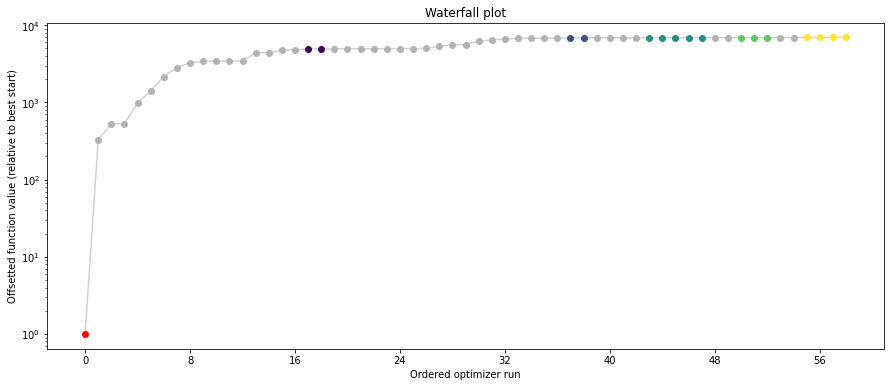

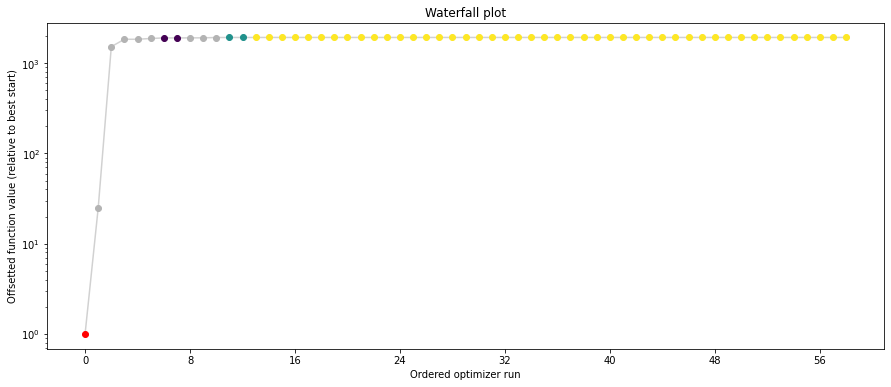

In [22]:
pypesto.visualize.waterfall(result, size=(15,6))
pypesto.visualize.waterfall(result2, size=(15,6))

In [23]:
result.optimize_result.get_for_key('fval')

[3069.930642008128,
 3393.478312520467,
 3599.095150899836,
 3599.6270282335677,
 4051.30511265327,
 4484.297526066286,
 5230.389128438384,
 5890.628295320637,
 6336.91846141333,
 6463.253337660664,
 6508.68069475996,
 6512.030756846749,
 6515.1259837798425,
 7462.444615271462,
 7484.144488643876,
 7814.975974417747,
 7880.354030137594,
 7994.394642288837,
 7994.413018506659,
 8008.302864220714,
 8011.014423887539,
 8012.090044523172,
 8012.352107687674,
 8016.1380259164025,
 8054.475301208518,
 8061.600495863766,
 8074.497619031203,
 8438.061508273604,
 8661.751136871824,
 8664.575321509785,
 9287.99923593938,
 9507.776762860833,
 9665.156028070332,
 9839.459054042498,
 9844.018514304014,
 9862.803420500026,
 9909.456686699696,
 9924.87013655223,
 9924.870217397254,
 9925.17602380901,
 9928.54349574456,
 9937.90677240958,
 9939.001638737285,
 9942.833790885876,
 9942.872079983586,
 9942.872101288065,
 9942.872103221158,
 9942.872103285961,
 9963.220643334344,
 9969.578166182333,
 9989

In [24]:
result2.optimize_result.get_for_key('fval')

[8081.474368872647,
 8105.346565678689,
 9608.451297409823,
 9924.870136097603,
 9925.176023816422,
 9961.463384094608,
 9989.286898176797,
 9989.286937611374,
 9991.031590073537,
 9993.208134879049,
 10009.400416393535,
 10010.553867134258,
 10010.58848989653,
 10011.532027874398,
 10011.53218467507,
 10011.532232676234,
 10011.53228436675,
 10011.532293945453,
 10011.532294255028,
 10011.532294255032,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 10011.532294255037,
 1001

In [8]:
print(sum(result.optimize_result.get_for_key('time')))
print(sum(result2.optimize_result.get_for_key('time')))

240.8520963191986
296.93090653419495
